In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch.utils.data import DataLoader

In [2]:
from dataHandler.dataset import MHDProjDataset,LogNormalTransform

from validationMetrics.powerSpectrum import power_spectrum_iso, plot_ps, plot_set_power_spectrum_iso
from validationMetrics.minkowskiFunctional import plot_mink_functionals

from ddpm.model import UNet
from ddpm.diffusion import DDPM, generate_image

In [3]:
### Experimental set-up
SOURCE_DIR='/mnt/home/dheurtel/ceph/00_exploration_data/planck_cham_noise/'

SAMPLE_FOLDER='/mnt/home/dheurtel/ceph/20_samples/artificial_architecture_exps/'  #For periodic samples
CKPT_FOLDER='/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps/' #For checkpoints and losses

In [4]:
exps=os.listdir(SAMPLE_FOLDER)
exps.sort()

**Chose now the experiment ID you want to check**

(Baselines are LN/32/dens and LN/32/toy)

In [5]:
SIZE=256
N_STEPS=1000
BATCH_SIZE=64

MODEL_ID1='PLANCKN_DDPM_skip_GN_bottleneck16_epochs10000_dim2'

SAMPLE_BATCH_SIZE1=16
RESULT_SAMPLE_SIZE1=64

SAMPLE_STEP_EPOCH1=200

NUM_EPOCHS1=1000

In [6]:
#dataset=MHDProjDataset(SOURCE_DIR,random_rotate=True,transforms=LogNormalTransform(),test_batch_length=95)
#SOURCE_DIR='/mnt/home/dheurtel/ceph/00_exploration_data/planck_cham_noise/'
dataset=MHDProjDataset(SOURCE_DIR,random_rotate=False,transforms=None,test_batch_length=0)
#dataset=MHDProjDataset(SOURCE_DIR,random_rotate=True,transforms=None,test_batch_length=128)

In [7]:
l1=os.listdir(os.path.join(SAMPLE_FOLDER,MODEL_ID1))
l1.sort()
l_results1=l1[:RESULT_SAMPLE_SIZE1]
l_samples1=l1[RESULT_SAMPLE_SIZE1:]



In [8]:
n_epoch_sampled1=len(l_samples1)//SAMPLE_BATCH_SIZE1

In [33]:
#data1=[np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID1,l_results1[i]),allow_pickle=True) for i in range(RESULT_SAMPLE_SIZE1)]
#data1=np.concatenate(data1)
#data1.shape
#data1=[np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID1,l_results1[i]),allow_pickle=True)[0].reshape(1,256,256) for i in range(RESULT_SAMPLE_SIZE1)]
data1=[np.sum(np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID1,l_results1[i]),allow_pickle=True), axis= 0).reshape(1,256,256) for i in range(RESULT_SAMPLE_SIZE1)]
data1=np.concatenate(data1)
data1.shape

(64, 256, 256)

In [34]:
dataset[0].shape

torch.Size([2, 256, 256])

In [36]:
#source_data_partial=np.concatenate([dataset[i].reshape(1,SIZE,SIZE) for i in range(256)])
#source_data_partial=np.concatenate([dataset[i][0].reshape(1,SIZE,SIZE) for i in range(256)])
source_data_partial=np.concatenate([torch.sum(dataset[i], axis = 0).reshape(1,SIZE,SIZE) for i in range(256)])

In [39]:
amin,amax=(-6.232629, 7.390278)

**Summary statistics computation and visualisation**

*Basics*

In [40]:
print(np.min(data1),np.max(data1))
print(np.min(source_data_partial),np.max(source_data_partial))

-9.03389 8.444963
-10.753621 9.4515


In [41]:
hist_data=np.histogram(source_data_partial.flatten(), bins=100, density=True)
hist_1=np.histogram(data1.flatten(), bins=100, density=True)

bins1=np.array([(hist_1[1][i]+hist_1[1][i+1])/2 for i in range(100)])
bins=np.array([(hist_data[1][i]+hist_data[1][i+1])/2 for i in range(100)])

n1=data1.size
n=source_data_partial.size

In [42]:
bins1.shape,hist_1[0].shape

((100,), (100,))

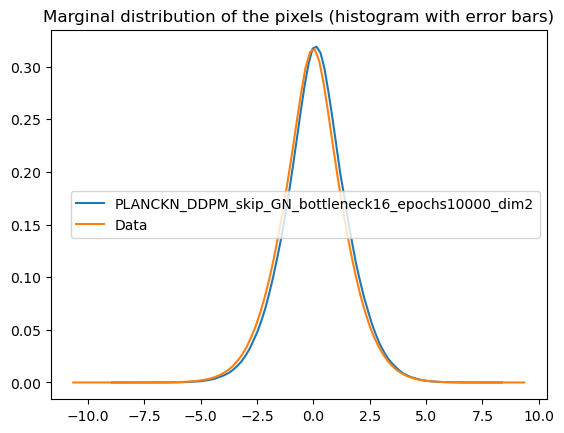

In [43]:
plt.plot(bins1,hist_1[0], label=MODEL_ID1)
plt.fill_between(bins1, hist_1[0]-np.sqrt(hist_1[0]*(1-hist_1[0])/n1),hist_1[0]+np.sqrt(hist_1[0]*(1-hist_1[0])/n1),alpha=0.25)
plt.plot(bins,hist_data[0], label='Data')
plt.fill_between(bins, hist_data[0]-np.sqrt(hist_data[0]*(1-hist_data[0])/n1),hist_data[0]+np.sqrt(hist_data[0]*(1-hist_data[0])/n1),alpha=0.25)
plt.title('Marginal distribution of the pixels (histogram with error bars)')
plt.legend()

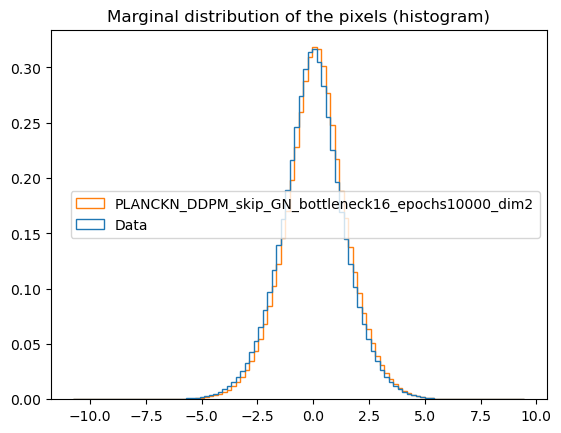

In [44]:
##Mean, STD, HIST pixel per pixel

plt.hist([source_data_partial.flatten(),data1.flatten()],label=['Data',MODEL_ID1],density=True,histtype='step',bins=100)
plt.title('Marginal distribution of the pixels (histogram)')
plt.legend()
plt.show()

In [45]:
def wasserstein(arr1,arr2):
    mean1, std1= np.mean(arr1), np.std(arr1)
    mean2, std2= np.mean(arr2), np.std(arr2)
    return (mean2-mean1)**2+(std1+std2-2*np.sqrt(std2*std1))

In [46]:
wasserstein(source_data_partial, data1)

0.020666071072938053

In [47]:
np_intermediate_samples1=[np.concatenate([np.load(os.path.join(SAMPLE_FOLDER,MODEL_ID1,l_samples1[i+SAMPLE_BATCH_SIZE1*j]),allow_pickle=True) for i in range(SAMPLE_BATCH_SIZE1)]) for j in range(n_epoch_sampled1)]

In [48]:
np_intermediate_pixels1=[arr.flatten() for arr in np_intermediate_samples1]

In [49]:
hist_todo1=np_intermediate_pixels1[5:]+[source_data_partial.flatten()]
labels1=['epoch_'+str(SAMPLE_STEP_EPOCH1*i) for i in range(5,n_epoch_sampled1)]+['source data']

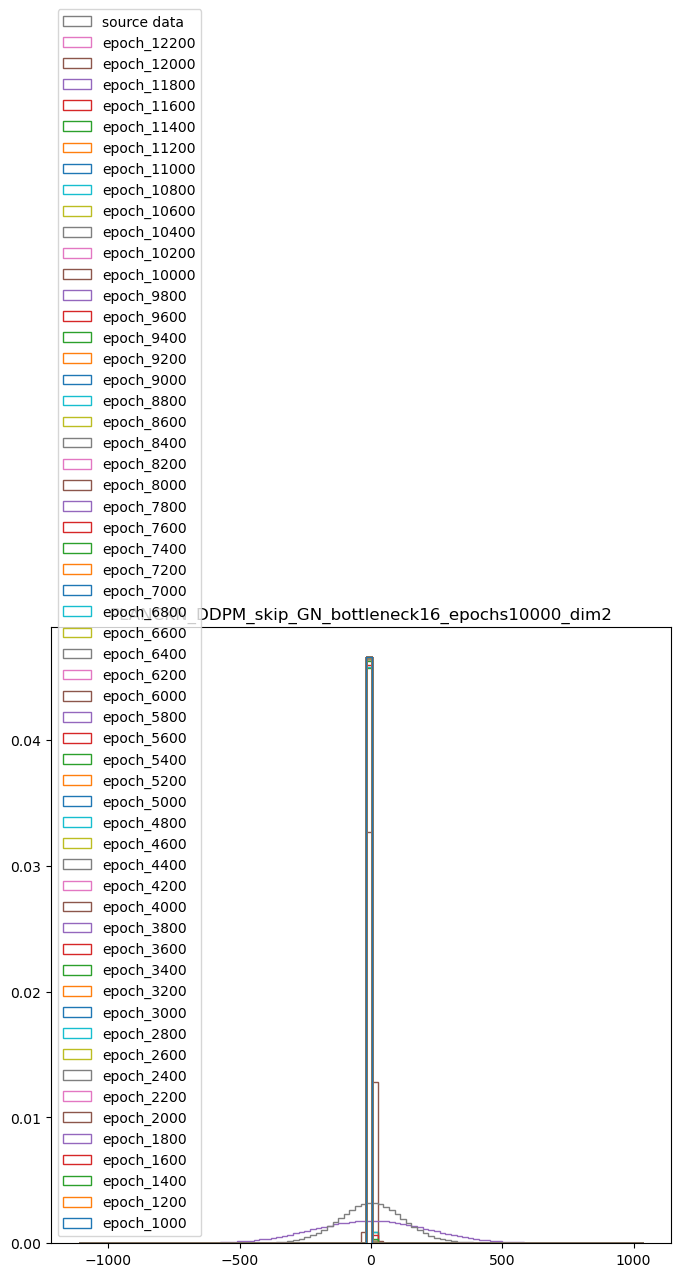

In [50]:
fig,ax= plt.subplots(1,1,figsize=(8,8))
ax.hist(hist_todo1,density=True,histtype='step',bins=100,label=labels1)

ax.title.set_text(MODEL_ID1)

ax.legend()

plt.show()

In [51]:
wass_2=[wasserstein(source_data_partial, np_intermediate_pixels1_epoch) for np_intermediate_pixels1_epoch in np_intermediate_pixels1]

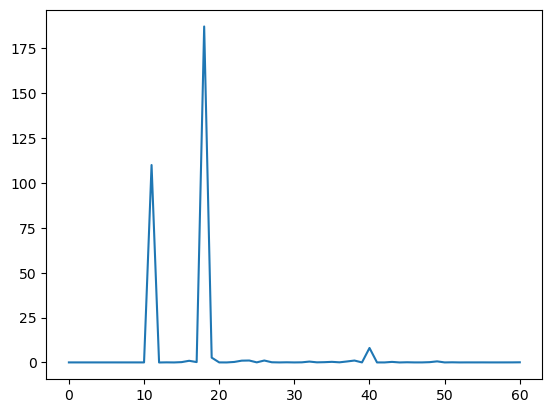

In [52]:
plt.plot(wass_2[1:])

*Power Spectrum*

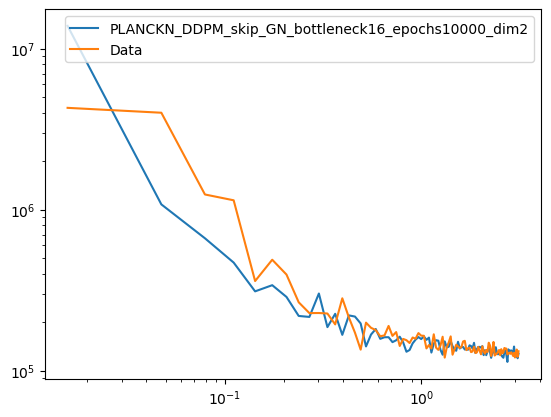

In [54]:
x1=data1[0]
bins = np.linspace(0, np.pi, 100)
_, ps_x1, _ = power_spectrum_iso(x1, bins=bins)
xdata=source_data_partial[0]
_, ps_xdata, _ = power_spectrum_iso(xdata, bins=bins)
plot_ps(bins, [ps_x1,ps_xdata], labels=[MODEL_ID1,'Data'],show=True)

1 2


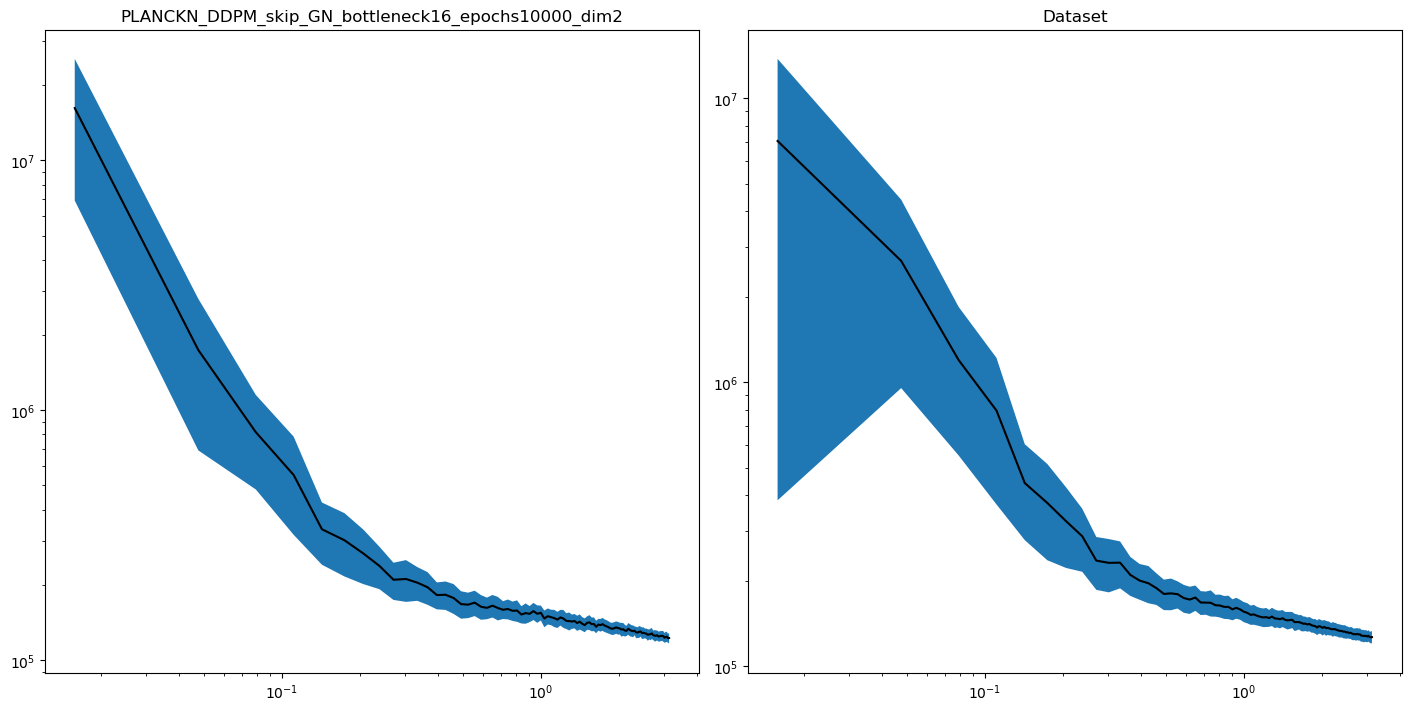

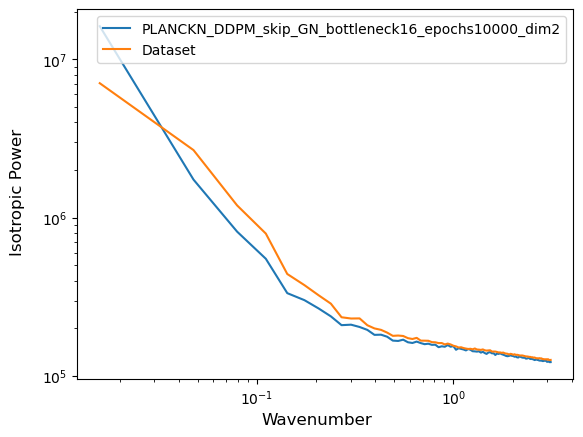

In [55]:
mean_list, bins_center, labels = plot_set_power_spectrum_iso([data1,source_data_partial], bins, labels=[MODEL_ID1,'Dataset'])

*Minkowski functional*

In [28]:
l_np_data_partial=[datapoint for datapoint in source_data_partial]
l_np_results_partial1=[datapoint for datapoint in data1]

In [29]:
RANGEMIN, RANGEMAX=-10,10

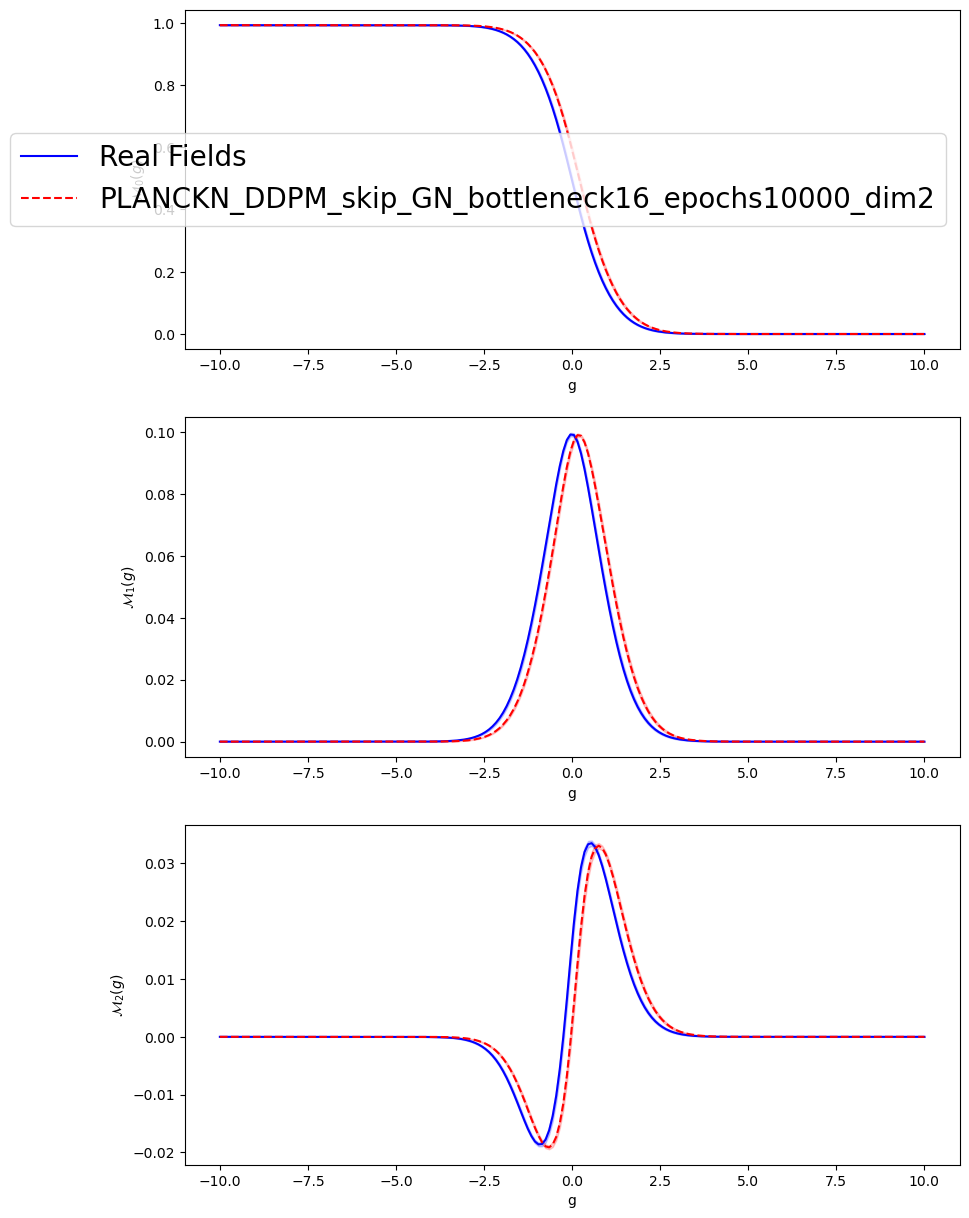

In [30]:
smm, sms=plot_mink_functionals([l_np_data_partial,l_np_results_partial1],gs_vals = np.linspace(RANGEMIN, RANGEMAX, 200),
                      names = ['Real Fields', MODEL_ID1], cols = ['b', 'r'], 
                      savefig_dict={})

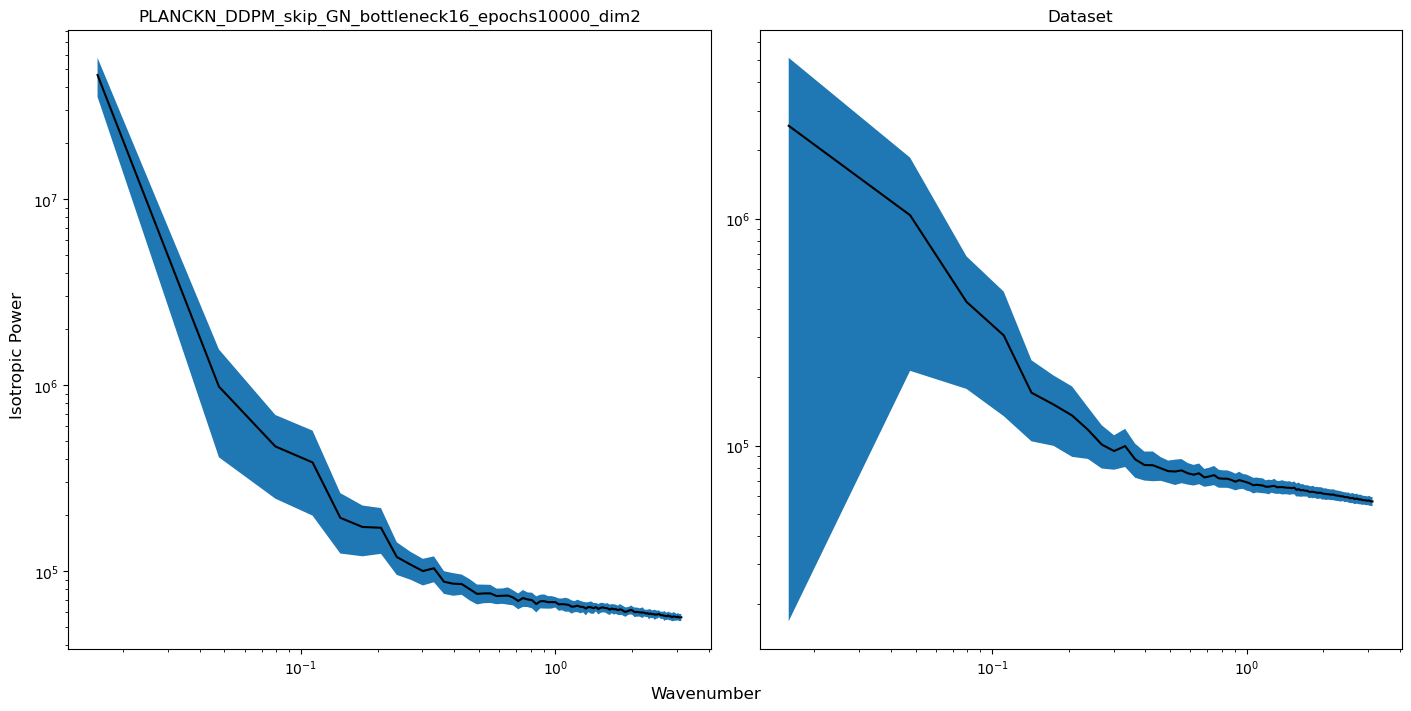

In [31]:
power_spectra1=np.concatenate([power_spectrum_iso(data_point,bins=bins)[1].reshape(1,100) for data_point in data1],axis=0)
true_power_spectra=np.concatenate([power_spectrum_iso(data_point,bins=bins)[1].reshape(1,100) for data_point in source_data_partial],axis=0)

bins_centers = (bins[:-1] + bins[1:])/2
    
fig, ax = plt.subplots(1, 2,figsize=(14,7), layout='constrained')
mean1,std1=np.mean(power_spectra1,axis=0)[:99],np.std(power_spectra1,axis=0)[:99]
true_mean,true_std=np.mean(true_power_spectra,axis=0)[:99],np.std(true_power_spectra,axis=0)[:99]

ax[0].plot(bins_centers,mean1,'-k')
ax[0].fill_between(bins_centers,mean1+std1,mean1-std1)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].title.set_text(MODEL_ID1)
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')

ax[1].plot(bins_centers,true_mean,'-k')
ax[1].fill_between(bins_centers,true_mean+true_std,true_mean-true_std)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].title.set_text('Dataset')

Text(0.5, 0.01, 'Wavenumber')

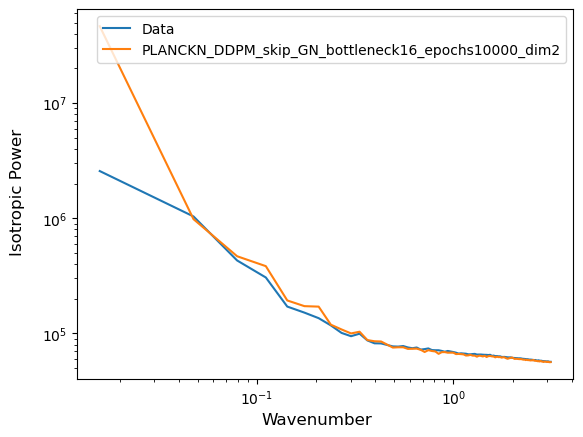

In [32]:
fig, ax = plt.subplots(1, 1)
ax.plot(bins_centers,true_mean,label='Data')
ax.plot(bins_centers,mean1,label=MODEL_ID1)
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()

fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')
